## 平时作业（1）：多层神经网络的训练

- 李锦韬 2201213292

### 作业要求

**请根据自己的计算环境情况和兴趣，选择以下两个数据集之一，完成如下的实验：**    
- http://yann.lecun.com/exdb/mnist/
- https://www.cs.toronto.edu/~kriz/cifar.html

**1. 构造一个多层的神经网络（注意，不要使用卷积神经网络，本题目要求使用多层神经网络），并在上述数据集任务上进行训练，并汇报一个“使用了你认为最优的超参数配置的神经网络”的学习曲线；要求如下：**
* （1）自己手动完成反向传播算法部分的编写；
* （2）该网络应为一个“纯净”的多层神经网络，不使用正则化方法、率优化算法等；

**2. 在上述“你认为最优配置的神经网络”的基础上，**
* （1）分别汇报“增加一个隐藏层”和“减小一个隐藏层”情况下的学习曲线； 
* （2）分别汇报使用BGD和SGD进行训练的学习曲线；
* （3）分别汇报使用两种以上参数初始化方法下的学习曲线；
* （4）分别汇报使用两种以上学习率优化算法下的学习曲线；
* （5）分别汇报使用两种以上正则化方法下的学习曲线；

**最终提交：包含6个子文件夹的一个zip文件，其中的子文件夹应包含：**
* （1）对应上述6种情况之一的一份源代码；
* （2）对应上述源代码的学习曲线的一个.png文件；

## 1. 构建基础网络
### 1.1 下载MNIST数据集

- 在网址http://yann.lecun.com/exdb/mnist/下载MNIST数据集
- 将下载的数据集解压到当前目录下的data文件夹中

In [1]:
import numpy as np
from urllib import request
import gzip
import pickle

filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], "../data/" + name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open("../data/" + name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open("../data/" + name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("../data/" + "mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init_mnist():
    download_mnist()
    save_mnist()
    
init_mnist()


Download complete.
Save complete.


### 1.2 MLP多层神经网络

- 不使用正则化方法和学习率优化方法
- 不适用卷积、池化等操作
- 使用numpy手工构造网络

**网络参数**

- 网络结构为：784-128-64-10
- 隐藏层激活函数为ReLU
- 输出层激活函数为Softmax
- 损失函数为交叉熵
- 优化器为MBGD
- 学习率为0.1
- BatchSize为64
- 迭代次数为25

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

# 获取MNIST数据集
def load_mnist():
    with open("../data/" + "mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]
X_train, y_train, X_test, y_test = load_mnist()

# 归一化处理
X_train = X_train / 255.0
X_test = X_test / 255.0

# 标准化处理
X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std

# 将标签转化为one-hot向量
n_classes = 10
y_train = np.eye(n_classes)[y_train]
y_test = np.eye(n_classes)[y_test]

# 定义网络结构
input_size = X_train.shape[1]
hidden_size_1 = 128
hidden_size_2 = 64
output_size = n_classes

# 初始化权重和偏置 采用随机初始化
W1 = np.random.randn(input_size, hidden_size_1) / np.sqrt(input_size)
b1 = np.zeros(hidden_size_1)
W2 = np.random.randn(hidden_size_1, hidden_size_2) / np.sqrt(hidden_size_1)
b2 = np.zeros(hidden_size_2)
W3 = np.random.randn(hidden_size_2, output_size) / np.sqrt(hidden_size_2)
b3 = np.zeros(output_size)

# 定义激活函数和损失函数
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exps = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exps / np.sum(exps, axis=-1, keepdims=True)

def cross_entropy_loss(y_pred, y_true):
    n_samples = y_pred.shape[0]
    loss = -np.sum(y_true * np.log(y_pred + 1e-12)) / n_samples
    return loss

# 定义训练函数
def train(X, y_true, learning_rate):
    global W1, W2, W3, b1, b2, b3
    # 前向传播
    z1 = np.dot(X, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2, W3) + b3
    y_pred = softmax(z3)
    m = y_true.shape[0]
    # 计算损失函数值和梯度
    loss = cross_entropy_loss(y_pred, y_true)

    grad_y_pred = y_pred - y_true

    grad_W3 = 1./m*np.dot(a2.T, grad_y_pred)
    grad_b3 = 1./m*np.sum(grad_y_pred, axis=0)
    grad_a2 = np.dot(grad_y_pred, W3.T)

    grad_z2 = grad_a2.copy()
    grad_z2[z2 < 0] = 0
    grad_W2 = 1./m*np.dot(a1.T, grad_z2)
    grad_b2 = 1./m*np.sum(grad_z2, axis=0)
    grad_a1 = np.dot(grad_z2, W2.T)

    grad_z1 = grad_a1.copy()
    grad_z1[z1 < 0] = 0
    grad_W1 = 1./m*np.dot(X.T, grad_z1)
    grad_b1 = 1./m*np.sum(grad_z1, axis=0)

    # 更新权重和偏置
    W3 -= learning_rate * grad_W3
    b3 -= learning_rate * grad_b3
    W2 -= learning_rate * grad_W2
    b2 -= learning_rate * grad_b2
    W1 -= learning_rate * grad_W1
    b1 -= learning_rate * grad_b1

    return loss

def predict(X):
    global W1, W2, W3, b1, b2, b3
    z1 = np.dot(X, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2, W3) + b3
    y_pred = softmax(z3)
    return np.argmax(y_pred, axis=-1)

learning_rate = 0.1
num_epochs = 25
batch_size = 64
num_batches = X_train.shape[0] // batch_size

train_loss_history = []
train_acc_history = []
test_acc_history = []
for epoch in range(num_epochs):
    # 在每个epoch前随机打乱训练数据
    permutation = np.random.permutation(X_train.shape[0])
    X_train = X_train[permutation]
    y_train = y_train[permutation]
    for i in range(num_batches):
        # 从训练数据中随机抽取一个batch
        X_batch = X_train[i * batch_size:(i + 1) * batch_size]
        y_batch = y_train[i * batch_size:(i + 1) * batch_size]

        # 训练一个batch，并记录损失函数值
        loss = train(X_batch, y_batch, learning_rate)
        train_loss_history.append(loss)

    # 计算训练集和测试集上的精度
    train_acc = np.mean(predict(X_train) == np.argmax(y_train, axis=-1))
    test_acc = np.mean(predict(X_test) == np.argmax(y_test, axis=-1))
    train_acc_history.append(train_acc)
    test_acc_history.append(test_acc)

    # 输出训练进度
    print('Epoch %d/%d, train loss: %f, train acc: %f, test acc: %f' % (epoch+1, num_epochs, loss, train_acc, test_acc))


Epoch 1/25, train loss: 0.136069, train acc: 0.966450, test acc: 0.961600
Epoch 2/25, train loss: 0.032315, train acc: 0.976983, test acc: 0.967700
Epoch 3/25, train loss: 0.054203, train acc: 0.976217, test acc: 0.966500
Epoch 4/25, train loss: 0.058701, train acc: 0.989233, test acc: 0.975700
Epoch 5/25, train loss: 0.036267, train acc: 0.988183, test acc: 0.974500
Epoch 6/25, train loss: 0.008098, train acc: 0.994150, test acc: 0.977400
Epoch 7/25, train loss: 0.034797, train acc: 0.994767, test acc: 0.975500
Epoch 8/25, train loss: 0.063993, train acc: 0.996350, test acc: 0.977900
Epoch 9/25, train loss: 0.008922, train acc: 0.996517, test acc: 0.976200
Epoch 10/25, train loss: 0.010356, train acc: 0.997517, test acc: 0.977200
Epoch 11/25, train loss: 0.026333, train acc: 0.999283, test acc: 0.979900
Epoch 12/25, train loss: 0.000021, train acc: 0.999367, test acc: 0.979400
Epoch 13/25, train loss: 0.001475, train acc: 0.999717, test acc: 0.978900
Epoch 14/25, train loss: 0.000809,

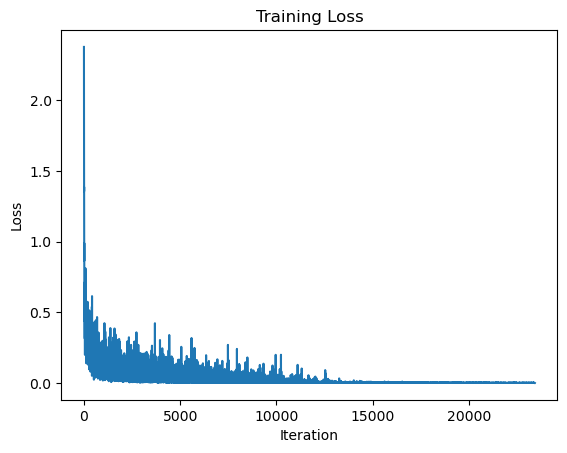

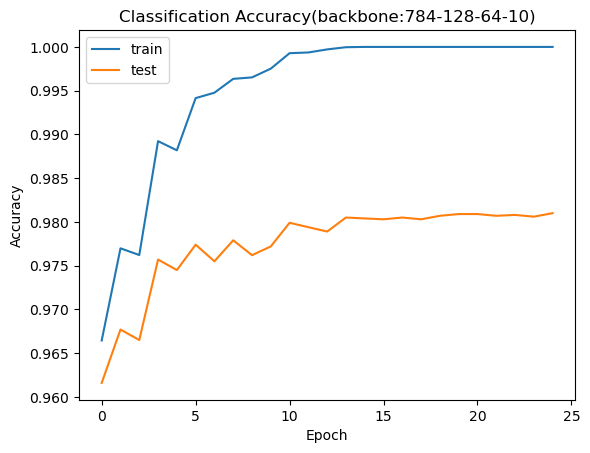

In [4]:
import matplotlib.pyplot as plt
plt.plot(train_loss_history)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

plt.plot(train_acc_history, label='train')
plt.plot(test_acc_history, label='test')
plt.title('Classification Accuracy(backbone:784-128-64-10)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('backbone.png')
plt.show()